Test Verisi doğruluk değeri (SVM): 70.1


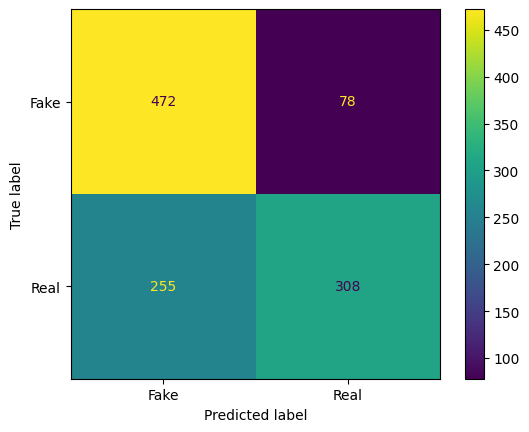

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Veri setlerini yükleme
real = pd.read_csv("islenmis_dogru_haberler.csv")
fake = pd.read_csv("islenmis_sahte_haberler.csv")

# Etiket ekleme
real['label'] = 1
fake['label'] = 0

# Veri setlerini birleştirme
df = pd.concat([real, fake], ignore_index=True)
X = df["Haber"]
y = df['label']

# Veri setini eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Word2Vec modeli oluşturma
word2vec_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4)

# Verileri Word2Vec vektörlerine dönüştürme
def word_averaging(model, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in model.wv.key_to_index:
            mean.append(model.wv[word])
            all_words.add(model.wv.key_to_index[word])
    
    if not mean:
        return np.zeros(model.vector_size,)
    
    mean = np.array(mean).mean(axis=0)
    return mean

def word_averaging_list(model, text_list):
    return np.vstack([word_averaging(model, post) for post in text_list])

X_train_word_average = word_averaging_list(word2vec_model, X_train)
X_test_word_average = word_averaging_list(word2vec_model, X_test)

# SVM modeli oluşturma ve eğitme
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_word_average, y_train)

# Test verisi üzerinde tahmin yapma
y_pred_svm = svm_model.predict(X_test_word_average)

# Doğruluk değerini hesaplama ve yazdırma
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('Test Verisi doğruluk değeri (SVM): %.1f'%(accuracy_svm*100))

# Confusion matrix oluşturma ve görselleştirme
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Fake', 'Real'])
disp_svm.plot()
plt.show()
